In [1]:
from torchdiffeq import odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact


#import Networkx as net
import Plot3D as plot3d
import dataframe as dataframe

In this file, I use PA-NODE's to learn a hystersis loop composed of saddle node bifurcations. This file differs from 2 as trajectories both x and t are varied as initial condiations, unlike verson 2 where only x was varied.

#### Neural ODE

In [2]:
class Simple_FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, activation_func=nn.Tanh()):
        super(Simple_FeedforwardNN, self).__init__()

        layers = []
        previous_depth = input_dim
        for _ in range(hidden_layers):
            layers.append(nn.Linear(previous_depth, depth))
            layers.append(activation_func)
            previous_depth = depth

        layers.append(nn.Linear(depth, output_dim))
        self.network = nn.Sequential(*layers)

        #Setting initial weights
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
            out = self.network(x)
            return out


In [3]:
class Piecewise_Auto_NODE(Simple_FeedforwardNN):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, domain, num_breakpoints, activation_func=nn.Tanh()):
        super().__init__(input_dim, hidden_layers, depth, output_dim*(num_breakpoints+1), activation_func)
        self.depth              = depth #Depth is number of neurons per hidden layer
        self.hiddenlayers       = hidden_layers #Number of internal hidden layers
        self.variables          = input_dim
        self.num_breakpoint     = num_breakpoints
        self.domain             = domain
        self.num_A              = (num_breakpoints+1)*output_dim
        self.breakpoints        = torch.linspace(domain[0], domain[1], num_breakpoints+2) 
        self.break_params       = nn.Parameter(self.breakpoints[1:-1])
        self.k = 1  #steepness parameter for sigmoid function
    
    
    def sigmoid(self, x):
       out = torch.sigmoid(self.k*x)
       return out
    


    def forward(self, t, x):
        out = self.network(x)

        #Getting indicator function
        #index = torch.where(self.break_params < t)[0].shape[0]
        #indicator = torch.concatenate([ torch.sigmoid(self.break_params - t)*((t < self.break_params).float()), torch.sigmoid(t - self.break_params)*((t > self.break_params).float())])
        #print(indicator); print('Break Param:', self.break_params)
        
        
        #First interval 
        i1 = self.sigmoid(self.break_params[0] - t).unsqueeze(0)
        output = i1

        #Internal Intervals
        for i in range(0, self.break_params.shape[0]-1):
            a = self.sigmoid(t - self.break_params[i]).unsqueeze(0)
            b = self.sigmoid(self.break_params[i+1] - t).unsqueeze(0)
            c = a*b
            output = torch.concatenate([output, c])
            
        #Final interval 
       
    
        i_final = self.sigmoid(t - self.break_params[-1]).unsqueeze(0)

        output = torch.cat([output, i_final])
     
        indicator = output
       
      
        out2 = out*indicator
      
        
        

        #out[0] = out[0]*(t < self.break_params).float()
        #out[1] = out[1]*(t >= self.break_params).float()
        final_out = torch.sum(out2, dim=0)
       

        return final_out.unsqueeze(0)
    
  

#### Model

In [4]:
class SaddleNodeHysteresis:
    def __init__(self, r):
        #Setting system parameters
        self.r = r
    

    #Differential Equation  
    def f(self, t, x): 
        xdot = (self.r(t)*2 - 1) + x - x**3

        return xdot

##### Sigmoid r(t)

In [5]:
k = 6
s_k = lambda t: torch.sigmoid(torch.tensor(k*t)).detach().numpy()

In [6]:
parameter_f = lambda t: 2*(s_k(t-6.0)*s_k(18.0 - t) ) -1

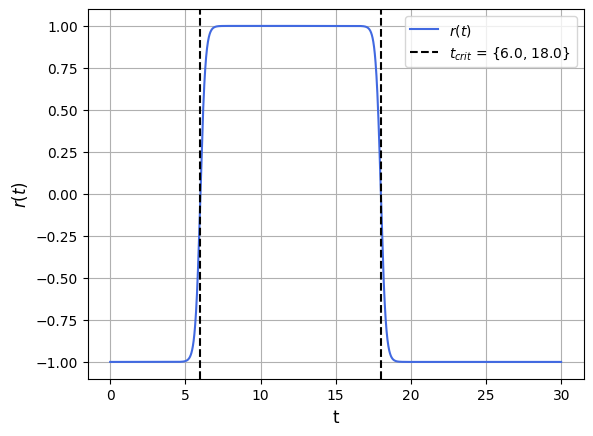

In [7]:
x= np.vectorize(parameter_f)(np.arange(0.0, 30.0, 0.01))
t = np.arange(0.0, 30.0, 0.01)
plt.plot(t, x, color='royalblue', label=r'$r(t)$')
plt.grid()
plt.xlabel('t', fontsize=12)
plt.ylabel(r'$r(t)$', fontsize=12)
plt.axvline(x=6.0, color='k', linestyle='--', label=r'$t_{crit}$ = {6.0, 18.0}')
plt.axvline(x=18.0, color='k', linestyle='--')

plt.legend()

##### Solve IVP

In [8]:
t_Start = 0; t_Final =30; dt = 0.05; t_Eval = np.arange(t_Start, t_Final, dt)
saddlenode = SaddleNodeHysteresis(r = parameter_f)

In [9]:
y0 = [-2, 1, 0, 1, 2]

In [10]:
t_start_pts = [0, 10, 20]

In [28]:
data = []
t_eval_list = []
for i in range(0, len(t_start_pts)):
    t_eval_temp = np.arange(t_start_pts[i], t_Final, dt)
    output = integ.solve_ivp(saddlenode.f, t_span=(t_start_pts[i], t_Final), y0=y0,
                            method = 'RK45', t_eval = t_eval_temp)
    data.append(output.y); t_eval_list.append(t_eval_temp)


In [34]:
print(t_eval_list[2].shape)
print(data[2].shape)

(200,)
(5, 200)


##### Plotting Solutions

In [35]:
t_eval = np.arange(t_Start, t_Final, dt)
x_eval = np.arange(-2, 2, 0.01)


x, y = np.meshgrid(t_eval, x_eval)
f = np.vectorize(saddlenode.f)(t=x, x=y)

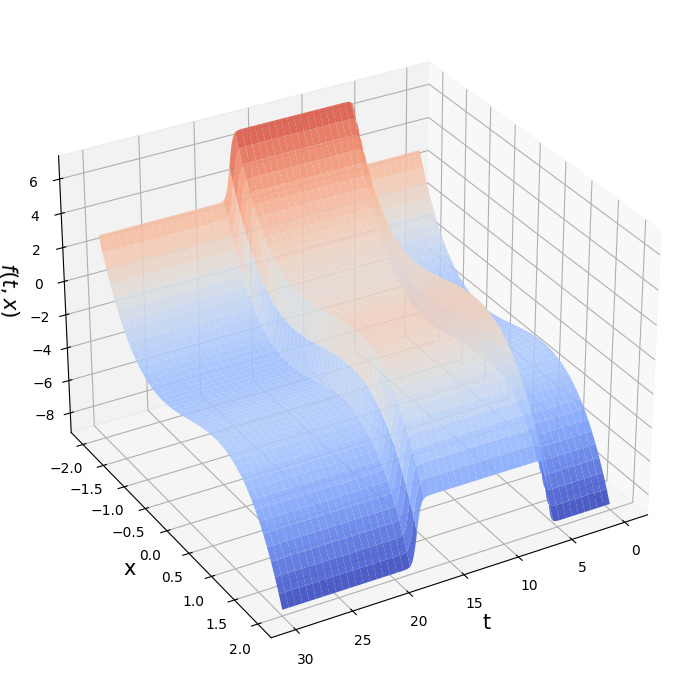

In [36]:
fig, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(10,7))
plt.tight_layout()

ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('x', fontsize=15)
ax.set_zlabel(r'$f(t, x)$', fontsize=15)

cmap = cm.coolwarm
#ax.plot(t_eval, output.y[0,:], np.vectorize(saddlenode.f)(t=t_Eval, x=output.y[0, :]), color = 'g', linewidth = 2 )
surf = ax.plot_surface(x, y, f, norm=colors.CenteredNorm(), cmap=cmap, alpha=0.9)

ax.view_init(elev = 30, azim = 60)
#ax.plot(xs=t_eval, ys=output.y[0,:], zs=np.vectorize(saddlenode.f)(t=t_eval, x=output.y[0, :]), color = 'black', linewidth = 5 )
#fig.colorbar(surf)
plt.show()

#### Training 

##### Batch Functions

In [37]:
#Batching function
def batch(data, t, batch_length, batch_size):
    data_length = data.shape[0]
    indices = np.random.randint(0, data_length - batch_length, batch_size)
    batch_list = []
    batch_time_list = []

    for i in range(0, batch_size):
        batch_list.append(data[indices[i]:indices[i]+batch_length, :].float())
        batch_time_list.append(t[indices[i]:indices[i]+batch_length].float().requires_grad_(True))

    return batch_list, batch_time_list
        


##### Model Parameters

In [48]:
# Model + Training Setup
model = Piecewise_Auto_NODE(input_dim=1, hidden_layers=2, depth = 15, output_dim=1, domain = [t_Start, t_Final], num_breakpoints=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
model.k = 1

batch_length = 100; batch_size = 5
loss_list = []

t_eval_tensor = torch.tensor(t_eval_list[0])
data1_tensor = torch.tensor(data[0][0, :])

In [49]:
torch.tensor(data[0][0, :]).shape
print(data1_tensor.shape)

torch.Size([600])


##### Training Loop

In [51]:
optimizer.zero_grad()
pred_x = odeint(model, torch.tensor([2.0]).float(), t_eval_tensor.float(), method='rk4', options={'step_size': dt})
train_loss = loss_fn(pred_x, data1_tensor.unsqueeze(0).T.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('')
print('Breakpoint: ', model.break_params)
print('')
print('Gradient of Breakpoint: ', model.break_params.grad)

Total Loss:  tensor(3.4955, grad_fn=<MseLossBackward0>)

Breakpoint:  Parameter containing:
tensor([10.0170, 19.9845], requires_grad=True)

Gradient of Breakpoint:  tensor([-0.0010, -0.0133])


In [52]:
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    #Set t0
    start_time = torch.randint(low = 0, high=len(t_eval_list), size=(1, ))[0]
    t_eval_tensor = torch.tensor(t_eval_list[start_time])

    #Selecting x0
    traj_num = torch.randint(low=0, high=data[start_time].shape[0], size=(1,))[0]
    data1_tensor = torch.tensor(data[start_time][traj_num, :])
    
    batch_list, batch_time_list = batch(data1_tensor.unsqueeze(0).T, t_eval_tensor, batch_length=batch_length, batch_size=batch_size)
    for i in range(0, batch_size):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model, batch_i[0], batch_time_i, method='rk4', options={'step_size': dt})

        #Calculating loss
        loss = loss_fn(pred_x, torch.tensor(batch_i))
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()
     
    
    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                pred_x = odeint(model, data1_tensor.unsqueeze(0)[:, 0].float(), t_eval_tensor, method='rk4', options={'step_size': 0.01})
                train_loss = loss_fn(pred_x, data1_tensor.unsqueeze(0).T)
                loss_list.append(train_loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\jackr\AppData\Local\Temp\ipykernel_26676\2873004247.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(pred_x, torch.tensor(batch_i))
  0%|          | 1/1000 [00:03<1:03:25,  3.81s/it]

Epoch 0, Loss: 1.7481048807058501


 10%|█         | 101/1000 [02:41<32:41,  2.18s/it]

Epoch 100, Loss: 0.3580935607334011


 20%|██        | 201/1000 [05:44<31:34,  2.37s/it]

Epoch 200, Loss: 0.00048460403581012334


 30%|███       | 301/1000 [08:49<25:38,  2.20s/it]

Epoch 300, Loss: 0.16921877787899806


 40%|████      | 401/1000 [11:40<20:09,  2.02s/it]

Epoch 400, Loss: 0.18616881483704975


 50%|█████     | 501/1000 [16:33<41:30,  4.99s/it]

Epoch 500, Loss: 0.005868757732933334


 60%|██████    | 601/1000 [23:00<28:48,  4.33s/it]

Epoch 600, Loss: 0.04499543757491809


 70%|███████   | 701/1000 [28:34<21:42,  4.36s/it]

Epoch 700, Loss: 0.05814661561595697


 80%|████████  | 801/1000 [34:22<07:02,  2.12s/it]

Epoch 800, Loss: 0.008201940815321704


 90%|█████████ | 901/1000 [36:58<03:10,  1.92s/it]

Epoch 900, Loss: 0.017254159130357435


100%|██████████| 1000/1000 [39:31<00:00,  2.37s/it]


##### Analysis

In [101]:
with torch.no_grad():
        pred_x = odeint(model, torch.tensor([-1.0]), t_eval_tensor, method='rk4', options={'step_size': 0.01})
        train_loss = loss_fn(pred_x, data1_tensor.T)
        #loss_list.append(train_loss.item())

c:\Users\jackr\OneDrive\Documents\GitHub\JackRoss-PhD-Notes\neural_odes\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([600])) that is different to the input size (torch.Size([600, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [372]:
train_loss

tensor(0.0016, dtype=torch.float64)

In [320]:
import Plot3D as plot3d

Text(0.5, 0, 'Epochs')

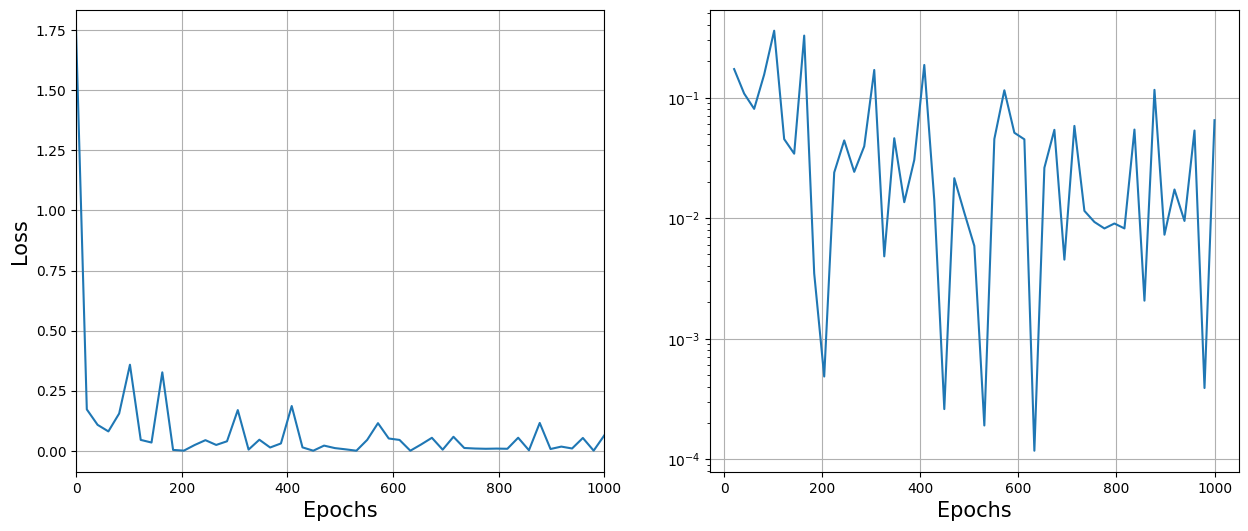

In [53]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, 1000, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, 1000)


ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, 1000, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
ax2.grid()
#plt.xscale('log')
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)


In [73]:
t_eval_tensor = torch.tensor(t_eval)
pred_x = odeint(model, torch.tensor([1.0]), t_eval_tensor, method='rk4', options={'step_size': 0.05})


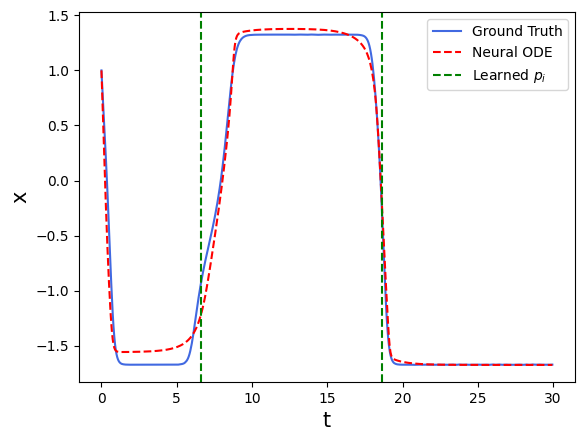

In [75]:
plt.plot(t_Eval, data[0][1, :], color='royalblue', label = 'Ground Truth')
plt.plot(t_Eval,  pred_x.detach().numpy(), color='r', linestyle='--', label='Neural ODE')
plt.xlabel('t', fontsize=15)
plt.ylabel('x', fontsize=15)


#plt.axvline(x = 6.0, color='k', linestyle='--', label='True '+r'$t_{crit}$')
#plt.axvline(x = 18.0, color='k', linestyle='--')


#plt.axvline(x = 3, color='k', linestyle='--', label='True '+r'$t_{crit}$')
plt.axvline(x = model.break_params[0].detach().numpy(), color='g', linestyle='--', label='Learned '+r'$p_i$')
plt.axvline(x = model.break_params[1].detach().numpy(), color='g', linestyle='--')
#plt.axvline(x = model.break_params.detach().numpy(), color='green', linestyle='--', label='Learned '+r'$t_{crit}$')
plt.legend()

In [151]:
model.break_params

Parameter containing:
tensor([ 7.2524, 18.5186], requires_grad=True)

##### Plotting Phase Space

In [56]:
t_Start

0

In [76]:
t_eval = np.arange(t_Start, t_Final, dt)
x_eval = np.arange(-2, 2, 0.01)
t, x = np.meshgrid(t_Eval, x_eval)
#f_hat = np.vectorize(saddlenode.f)(t=t, x=x)


In [77]:
def f_hat_func(t, x):
    a = model.forward(t, torch.tensor([x], dtype=torch.float32)).detach().numpy()
    return a
    
f_hat = np.vectorize(f_hat_func)(t=t, x = x)

In [78]:
pred_x = odeint(model, torch.tensor([-1.0]), t_eval_tensor, method='rk4', options={'step_size': 0.05})

In [79]:
f_hat_func_vector = np.vectorize(f_hat_func)
a = pred_x.detach().numpy().flatten()
traj1 = f_hat_func_vector(t=t_eval, x=a)


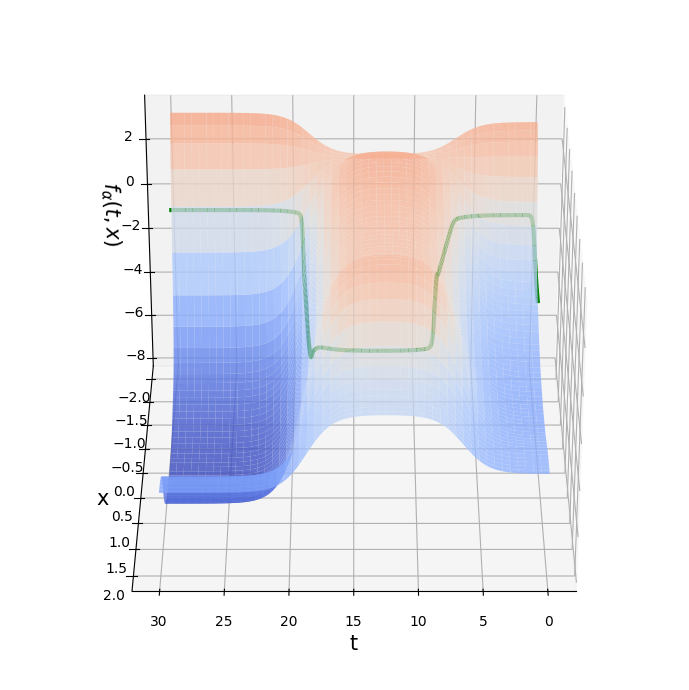

In [83]:
fig, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(10,7))
plt.tight_layout()

ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('x', fontsize=15)
ax.set_zlabel(r'$f_{\alpha}(t, x)$', fontsize=15)

cmap = cm.coolwarm
#ax.plot(t_eval, output.y, np.vectorize(saddlenode.f)(t=t_eval, x=output.y[0, :]), color = 'g', linewidth = 3 )
surf = ax.plot_surface(t, x, f_hat, norm=colors.CenteredNorm(), cmap=cmap, alpha=0.8)

ax.view_init(elev = 30, azim = 90)
ax.plot(xs=t_eval, ys=pred_x.detach().numpy().flatten(), zs=traj1, color = 'g', linewidth = 3 )
#fig.colorbar(surf)
plt.show()

In [167]:
t_eval = np.arange(t_Start, t_Final, dt)
x_eval = np.arange(-10, 10, 0.05)
t_new, x_new = np.meshgrid(t_eval, x_eval)
f_hat_new = np.vectorize(f_hat_func)(t=t_new, x=x_new)


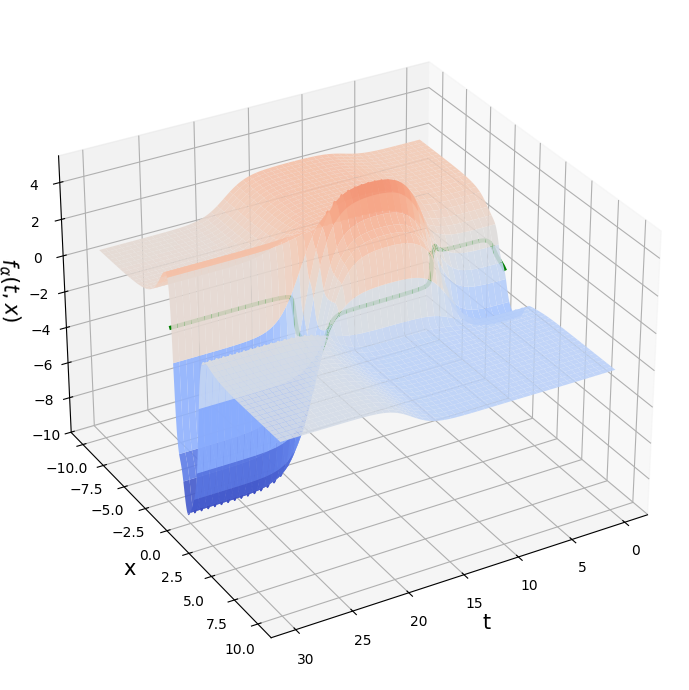

In [168]:
fig, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(10,7))
plt.tight_layout()

ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('x', fontsize=15)
ax.set_zlabel(r'$f_{\alpha}(t, x)$', fontsize=15)

cmap = cm.coolwarm
#ax.plot(t_eval, output.y[0,:], np.vectorize(saddlenode.f)(t=t_eval, x=output.y[0, :]), color = 'g', linewidth = 2 )
surf = ax.plot_surface(t_new, x_new, f_hat_new, norm=colors.CenteredNorm(), cmap=cmap, alpha=0.9)

ax.view_init(elev = 30, azim = 60)
ax.plot(xs=t_eval, ys=pred_x.detach().numpy().flatten(), zs=traj1, color = 'g', linewidth = 3 )
#fig.colorbar(surf)
plt.show()

### Bifurcation Diagram